# 第 12  章 pandas  高级应用
前面的章节关注于不同类型的数据规整流程和 NumPy、pandas 与其它库的特
点。随着时间的发展，pandas 发展出了更多适合高级用户的功能。本章就要深
入学习 pandas 的高级功能。
## 12.1 分类数据
这一节介绍的是 pandas 的分类类型。我会向你展示通过使用它，提高性能和内
存的使用率。我还会介绍一些在统计和机器学习中使用分类数据的工具。
### 背景和目的
表中的一列通常会有重复的包含不同值的小集合的情况。我们已经学过了
unique 和 value_counts，它们可以从数组提取出不同的值，并分别计算频率：

In [1]:
import numpy as np; import pandas as pd

In [2]:
values = pd.Series(['apple', 'orange', 'apple', 'apple'] * 2)

In [3]:
values

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
dtype: object

In [4]:
pd.unique(values)

array(['apple', 'orange'], dtype=object)

In [5]:
pd.value_counts(values)

apple     6
orange    2
dtype: int64

许多数据系统（数据仓库、统计计算或其它应用）都发展出了特定的表征重复
值的方法，以进行高效的存储和计算。在数据仓库中，最好的方法是使用所谓
的包含不同值得维表(Dimension Table)，将主要的参数存储为引用维表整数
键：

In [6]:
values = pd.Series([0, 1, 0, 0] * 2)

In [7]:
dim = pd.Series(['apple', 'orange'])

In [8]:
values

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    0
dtype: int64

In [9]:
dim

0     apple
1    orange
dtype: object

可以使用 take 方法存储原始的字符串 Series：

In [10]:
dim.take(values)

0     apple
1    orange
0     apple
0     apple
0     apple
1    orange
0     apple
0     apple
dtype: object

这种用整数表示的方法称为分类或字典编码表示法。不同值得数组称为分类、
字典或数据级。本书中，我们使用分类的说法。表示分类的整数值称为分类编
码或简单地称为编码。
分类表示可以在进行分析时大大的提高性能。你也可以在保持编码不变的情况
下，对分类进行转换。一些相对简单的转变例子包括：
-  重命名分类。
-  加入一个新的分类，不改变已经存在的分类的顺序或位置。

### pandas 的分类类型
pandas 有一个特殊的分类类型，用于保存使用整数分类表示法的数据。看一个
之前的 Series 例子：

In [11]:
fruits = ['apple', 'orange', 'apple', 'apple'] * 2

In [12]:
N = len(fruits)

In [13]:
df = pd.DataFrame({'fruit': fruits,
                   'basket_id': np.arange(N),
                   'count': np.random.randint(3, 15, size=N),
                   'weight': np.random.uniform(0, 4, size=N)},
                  columns=['basket_id', 'fruit', 'count', 'weight'])

In [14]:
df

,basket_id,fruit,count,weight
0,0,apple,8,2.398513
1,1,orange,4,1.059813
2,2,apple,11,2.218539
3,3,apple,8,1.507827
4,4,apple,14,1.500091
5,5,orange,8,2.929410
6,6,apple,5,0.151822
7,7,apple,8,3.258344


这里，`df['fruit']`是一个 Python 字符串对象的数组。我们可以通过调用它，
将它转变为分类：

In [15]:
fruit_cat = df['fruit'].astype('category')

In [16]:
fruit_cat

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): [apple, orange]

fruit_cat 的值不是 NumPy 数组，而是一个 pandas.Categorical 实例：

In [17]:
c = fruit_cat.values

In [18]:
type(c)

pandas.core.arrays.categorical.Categorical

分类对象有 categories 和 codes 属性：

In [19]:
c.categories

Index(['apple', 'orange'], dtype='object')

In [20]:
c.codes

array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int8)

你可将 DataFrame 的列通过分配转换结果，转换为分类：

In [21]:
df['fruit'] = df['fruit'].astype('category')

In [22]:
df.fruit

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): [apple, orange]

你还可以从其它 Python 序列直接创建 pandas.Categorical：

In [23]:
my_categories = pd.Categorical(['foo', 'bar', 'baz', 'foo', 'bar'])

In [24]:
my_categories

[foo, bar, baz, foo, bar]
Categories (3, object): [bar, baz, foo]

如果你已经从其它源获得了分类编码，你还可以使用 from_codes 构造器：

In [25]:
categories = ['foo', 'bar', 'baz']

In [26]:
codes = [0, 1, 2, 0, 0, 1]

In [27]:
my_cats_2 = pd.Categorical.from_codes(codes, categories)

In [28]:
my_cats_2

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo, bar, baz]

与显示指定不同，分类变换不认定指定的分类顺序。因此取决于输入数据的顺
序，categories 数组的顺序会不同。当使用 from_codes 或其它的构造器时，
你可以指定分类一个有意义的顺序：

In [29]:
ordered_cat = pd.Categorical.from_codes(codes, categories, ordered=True)

In [30]:
ordered_cat

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo < bar < baz]

输出[foo < bar < baz]指明‘foo’位于‘bar’的前面，以此类推。无序的分
类实例可以通过 as_ordered 排序：

In [31]:
my_cats_2.as_ordered()

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo < bar < baz]

最后要注意，分类数据不需要字符串，尽管我仅仅展示了字符串的例子。分类
数组可以包括任意不可变类型。
### 用分类进行计算
与非编码版本（比如字符串数组）相比，使用 pandas 的 Categorical 有些类
似。某些 pandas 组件，比如 groupby 函数，更适合进行分类。还有一些函数可
以使用有序标志位。

来看一些随机的数值数据，使用 pandas.qcut 面元函数。它会返回
pandas.Categorical，我们之前使用过 pandas.cut，但没解释分类是如何工作
的：

In [32]:
np.random.seed(12345)

In [33]:
draws = np.random.randn(1000)

In [34]:
draws[:5]

array([-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057])

计算这个数据的分位面元，提取一些统计信息：

In [35]:
bins = pd.qcut(draws, 4)

In [36]:
bins

[(-0.684, -0.0101], (-0.0101, 0.63], (-0.684, -0.0101], (-0.684, -0.0101], (0.63, 3.928], ..., (-0.0101, 0.63], (-0.684, -0.0101], (-2.9499999999999997, -0.684], (-0.0101, 0.63], (0.63, 3.928]]
Length: 1000
Categories (4, interval[float64]): [(-2.9499999999999997, -0.684] < (-0.684, -0.0101] < (-0.0101, 0.63] < (0.63, 3.928]]

虽然有用，确切的样本分位数与分位的名称相比，不利于生成汇总。我们可以
使用 labels 参数 qcut，实现目的：

In [37]:
bins = pd.qcut(draws, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [38]:
bins

[Q2, Q3, Q2, Q2, Q4, ..., Q3, Q2, Q1, Q3, Q4]
Length: 1000
Categories (4, object): [Q1 < Q2 < Q3 < Q4]

In [39]:
bins.codes[:10]

array([1, 2, 1, 1, 3, 3, 2, 2, 3, 3], dtype=int8)

加上标签的面元分类不包含数据面元边界的信息，因此可以使用 groupby 提取
一些汇总信息：

In [40]:
bins = pd.Series(bins, name='quartile')

In [41]:
results = (pd.Series(draws)
           .groupby(bins)
           .agg(['count', 'min', 'max'])
           .reset_index())

In [42]:
results

,quartile,count,min,max
0,Q1,250,-2.949343,-0.685484
1,Q2,250,-0.683066,-0.010115
2,Q3,250,-0.010032,0.628894
3,Q4,250,0.634238,3.927528


分位数列保存了原始的面元分类信息，包括排序：

In [43]:
results['quartile']

0    Q1
1    Q2
2    Q3
3    Q4
Name: quartile, dtype: category
Categories (4, object): [Q1 < Q2 < Q3 < Q4]

### 用分类提高性能
如果你是在一个特定数据集上做大量分析，将其转换为分类可以极大地提高效
率。DataFrame 列的分类使用的内存通常少的多。来看一些包含一千万元素的
Series，和一些不同的分类：

In [44]:
N = 10000000

In [45]:
draws = pd.Series(np.random.randn(N))

In [46]:
labels = pd.Series(['foo', 'bar', 'baz', 'qux'] * (N // 4))

现在，将标签转换为分类：

In [47]:
categories = labels.astype('category')

这时，可以看到标签使用的内存远比分类多：

In [48]:
labels.memory_usage()

80000080

In [49]:
categories.memory_usage()

10000272

转换为分类不是没有代价的，但这是一次性的代价：

In [50]:
%time _ = labels.astype('category')

Wall time: 680 ms


GroupBy 操作明显比分类快，是因为底层的算法使用整数编码数组，而不是字
符串数组。
### 分类方法
包含分类数据的 Series 有一些特殊的方法，类似于 Series.str 字符串方法。
它还提供了方便的分类和编码的使用方法。看下面的 Series：

In [51]:
s = pd.Series(['a', 'b', 'c', 'd'] * 2)

In [52]:
cat_s = s.astype('category')

In [53]:
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): [a, b, c, d]

特别的 cat 属性提供了分类方法的入口：

In [54]:
cat_s.cat.codes

0    0
1    1
2    2
3    3
4    0
5    1
6    2
7    3
dtype: int8

In [55]:
cat_s.cat.categories

Index(['a', 'b', 'c', 'd'], dtype='object')

假设我们知道这个数据的实际分类集，超出了数据中的四个值。我们可以使用
set_categories 方法改变它们：

In [56]:
actual_categories = ['a', 'b', 'c', 'd', 'e']

In [57]:
cat_s2 = cat_s.cat.set_categories(actual_categories)

In [58]:
cat_s2

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (5, object): [a, b, c, d, e]

虽然数据看起来没变，新的分类将反映在它们的操作中。例如，如果有的话，
value_counts 表示分类：

In [59]:
cat_s.value_counts()

d    2
c    2
b    2
a    2
dtype: int64

In [60]:
cat_s2.value_counts()

d    2
c    2
b    2
a    2
e    0
dtype: int64

在打数据集中，分类经常作为节省内存和高性能的便捷工具。过滤完大
DataFrame 或 Series 之后，许多分类可能不会出现在数据中。我们可以使用
remove_unused_categories 方法删除没看到的分类：

In [61]:
cat_s3 = cat_s[cat_s.isin(['a', 'b'])]

In [62]:
cat_s3

0    a
1    b
4    a
5    b
dtype: category
Categories (4, object): [a, b, c, d]

In [63]:
cat_s3.cat.remove_unused_categories()

0    a
1    b
4    a
5    b
dtype: category
Categories (2, object): [a, b]

表 12-1 列出了可用的分类方法。

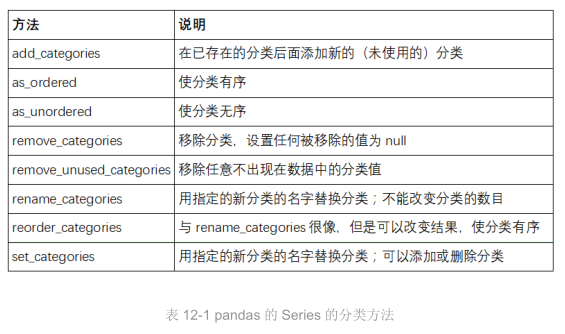

### 为建模创建虚拟变量
当你使用统计或机器学习工具时，通常会将分类数据转换为虚拟变量，也称为
one-hot 编码。这包括创建一个不同类别的列的 DataFrame；这些列包含给定分
类的 1s，其它为 0。

看前面的例子：

In [64]:
cat_s = pd.Series(['a', 'b', 'c', 'd'] * 2, dtype='category')

前面的第 7 章提到过，pandas.get_dummies 函数可以转换这个以为分类数据为
包含虚拟变量的 DataFrame：

In [65]:
pd.get_dummies(cat_s)

,a,b,c,d
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1


## 12.2 GroupBy 高级应用
尽管我们在第 10 章已经深度学习了 Series 和 DataFrame 的 Groupby 方法，还
有一些方法也是很有用的。
### 分组转换和“解封”GroupBy
在第 10 章，我们在分组操作中学习了 apply 方法，进行转换。还有另一个
transform 方法，它与 apply 很像，但是对使用的函数有一定限制：
-  它可以产生向分组形状广播标量值
-  它可以产生一个和输入组形状相同的对象
-  它不能修改输入

来看一个简单的例子：

In [2]:
df = pd.DataFrame({'key': ['a', 'b', 'c'] * 4,
                   'value': np.arange(12.)})

In [3]:
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


按键进行分组：

In [4]:
g = df.groupby('key').value

In [5]:
g.mean()

key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

假设我们想产生一个和 df['value']形状相同的 Series，但值替换为按键分组
的平均值。我们可以传递函数 lambda x: x.mean()进行转换：

In [6]:
g.transform(lambda x: x.mean())

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

对于内置的聚合函数，我们可以传递一个字符串假名作为 GroupBy 的 agg 方
法：

In [7]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

与 apply 类似，transform 的函数会返回 Series，但是结果必须与输入大小相
同。举个例子，我们可以用 lambda 函数将每个分组乘以 2：

In [8]:
g.transform(lambda x: x * 2)

0      0.0
1      2.0
2      4.0
3      6.0
4      8.0
5     10.0
6     12.0
7     14.0
8     16.0
9     18.0
10    20.0
11    22.0
Name: value, dtype: float64

再举一个复杂的例子，我们可以计算每个分组的降序排名：

In [9]:
g.transform(lambda x: x.rank(ascending=False))

0     4.0
1     4.0
2     4.0
3     3.0
4     3.0
5     3.0
6     2.0
7     2.0
8     2.0
9     1.0
10    1.0
11    1.0
Name: value, dtype: float64

看一个由简单聚合构造的的分组转换函数：

In [10]:
def normalize(x):
    return (x - x.mean()) / x.std()

我们用 transform 或 apply 可以获得等价的结果：

In [11]:
g.transform(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [12]:
g.apply(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

内置的聚合函数，比如 mean 或 sum，通常比 apply 函数快，也比 transform
快。这允许我们进行一个所谓的解封（unwrapped）分组操作：

In [13]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [14]:
normalized = (df['value'] - g.transform('mean')) / g.transform('std')

In [15]:
normalized

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

解封分组操作可能包括多个分组聚合，但是矢量化操作还是会带来收益。
### 分组的时间重采样
对于时间序列数据，resample 方法从语义上是一个基于内在时间的分组操作。
下面是一个示例表：

In [16]:
N = 15

In [17]:
times = pd.date_range('2017-05-20 00:00', freq='1min', periods=N)

In [18]:
df = pd.DataFrame({'time': times,
                   'value': np.arange(N)})

In [19]:
df

,time,value
0,2017-05-20 00:00:00,0
1,2017-05-20 00:01:00,1
2,2017-05-20 00:02:00,2
3,2017-05-20 00:03:00,3
4,2017-05-20 00:04:00,4
5,2017-05-20 00:05:00,5
6,2017-05-20 00:06:00,6
7,2017-05-20 00:07:00,7
8,2017-05-20 00:08:00,8
9,2017-05-20 00:09:00,9


这里，我们可以用 time 作为索引，然后重采样：

In [21]:
df.set_index('time').resample('5min').count()

,value
time,
2017-05-20 00:00:00,5
2017-05-20 00:05:00,5
2017-05-20 00:10:00,5


假设 DataFrame 包含多个时间序列，用一个额外的分组键的列进行标记：

In [22]:
df2 = pd.DataFrame({'time': times.repeat(3),
                    'key': np.tile(['a', 'b', 'c'], N),
                    'value': np.arange(N * 3.)})

要对每个 key 值进行相同的重采样，我们引入 pandas.TimeGrouper 对象：

In [24]:
time_key = pd.TimeGrouper('5min')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


我们然后设定时间索引，用 key 和 time_key 分组，然后聚合：

In [25]:
resampled = (df2.set_index('time')
             .groupby(['key', time_key])
             .sum())

In [26]:
resampled

value
key time                      
a   2017-05-20 00:00:00   30.0
    2017-05-20 00:05:00  105.0
    2017-05-20 00:10:00  180.0
b   2017-05-20 00:00:00   35.0
    2017-05-20 00:05:00  110.0
    2017-05-20 00:10:00  185.0
c   2017-05-20 00:00:00   40.0
    2017-05-20 00:05:00  115.0
    2017-05-20 00:10:00  190.0

In [27]:
resampled.reset_index()

,key,time,value
0,a,2017-05-20 00:00:00,30.0
1,a,2017-05-20 00:05:00,105.0
2,a,2017-05-20 00:10:00,180.0
3,b,2017-05-20 00:00:00,35.0
4,b,2017-05-20 00:05:00,110.0
5,b,2017-05-20 00:10:00,185.0
6,c,2017-05-20 00:00:00,40.0
7,c,2017-05-20 00:05:00,115.0
8,c,2017-05-20 00:10:00,190.0


使用 TimeGrouper 的限制是时间必须是 Series 或 DataFrame 的索引。
## 12.3 链式编程技术
当对数据集进行一系列变换时，你可能发现创建的多个临时变量其实并没有在
分析中用到。看下面的例子：

In [28]:
df = load_data()
df2 = df[df['col2'] < 0]
df2['col1_demeaned'] = df2['col1'] - df2['col1'].mean()
result = df2.groupby('key').col1_demeaned.std()

NameError: name 'load_data' is not defined

虽然这里没有使用真实的数据，这个例子却指出了一些新方法。首先，
DataFrame.assign 方法是一个 df[k] = v 形式的函数式的列分配方法。它不是
就地修改对象，而是返回新的修改过的 DataFrame。因此，下面的语句是等价
的：

In [29]:
# Usual non-functional way
df2 = df.copy()
df2['k'] = v
# Functional assign way
df2 = df.assign(k=v)

NameError: name 'v' is not defined

就地分配可能会比 assign 快，但是 assign 可以方便地进行链式编程：

In [30]:
result = (df2.assign(col1_demeaned=df2.col1 - df2.col2.mean())
          .groupby('key')
          .col1_demeaned.std())

AttributeError: 'DataFrame' object has no attribute 'col1'

我使用外括号，这样便于添加换行符。
使用链式编程时要注意，你可能会需要涉及临时对象。在前面的例子中，我们
不能使用 load_data 的结果，直到它被赋值给临时变量 df。为了这么做，
assign 和许多其它 pandas 函数可以接收类似函数的参数，即可调用对象
（callable）。为了展示可调用对象，看一个前面例子的片段：

In [31]:
df = load_data()
df2 = df[df['col2'] < 0]

NameError: name 'load_data' is not defined

它可以重写为：

In [33]:
df = (load_data()[lambda x: x['col2'] < 0])

NameError: name 'load_data' is not defined

这里，load_data 的结果没有赋值给某个变量，因此传递到[ ]的函数在这一步
被绑定到了对象。
我们可以把整个过程写为一个单链表达式：

In [34]:
result = (load_data()[lambda x: x.col2 < 0]
          .assign(col1_demeaned=lambda x: x.col1 - x.col1.mean())
          .groupby('key')
          .col1_demeaned.std())

NameError: name 'load_data' is not defined

是否将代码写成这种形式只是习惯而已，将它分开成若干步可以提高可读性。
### 管道方法
你可以用 Python 内置的 pandas 函数和方法，用带有可调用对象的链式编程做
许多工作。但是，有时你需要使用自己的函数，或是第三方库的函数。这时就
要用到管道方法。
看下面的函数调用：

In [35]:
a = f(df, arg1=v1)
b = g(a, v2, arg3=v3)
c = h(b, arg4=v4)

NameError: name 'f' is not defined

当使用接收、返回 Series 或 DataFrame 对象的函数式，你可以调用 pipe 将其
重写：

In [36]:
result = (df.pipe(f, arg1=v1)
          .pipe(g, v2, arg3=v3)
          .pipe(h, arg4=v4))

NameError: name 'f' is not defined

f(df)和 df.pipe(f)是等价的，但是 pipe 使得链式声明更容易。
pipe 的另一个有用的地方是提炼操作为可复用的函数。看一个从列减去分组方
法的例子：

In [37]:
g = df.groupby(['key1', 'key2'])
df['col1'] = df['col1'] - g.transform('mean')

KeyError: 'key1'

假设你想转换多列，并修改分组的键。另外，你想用链式编程做这个转换。下
面就是一个方法：

In [38]:
def group_demean(df, by, cols):
    result = df.copy()
    g = df.groupby(by)
    for c in cols:
        result[c] = df[c] - g[c].transform('mean')
    return result

然后可以写为：

In [39]:
result = (df[df.col1 < 0]
          .pipe(group_demean, ['key1', 'key2'], ['col1']))

AttributeError: 'DataFrame' object has no attribute 'col1'

## 12.4 总结
和其它许多开源项目一样，pandas 仍然在不断的变化和进步中。和本书中其它
地方一样，这里的重点是放在接下来几年不会发生什么改变且稳定的功能。
为了深入学习 pandas 的知识，我建议你学习官方文档，并阅读开发团队发布的
更新文档。我们还邀请你加入 pandas 的开发工作：修改 bug、创建新功能、完
善文档。